# Estimated Minus Final Reward (2x3 Grid)

This notebook plots `estimated_reward_t - final_reward` by timestep for each model/reward pair.

- Rows: `EDM`, `SD`
- Cols: `brightness`, `compressibility`, `classifier/clip`

Definitions used here:
- `estimated_reward_t`: winner score at timestep `t` after the final local-search iteration (`k = max local_iter_idx`)
- `final_reward`: `run_end.best_score` when available; otherwise fallback to estimated reward at the last timestep

Note: in current logs, EDM `timestep_value` is sigma-like; SD `timestep_value` is DDIM timestep index.


In [23]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import LogLocator, LogFormatterMathtext

plt.style.use('seaborn-v0_8-whitegrid')


In [24]:
# -------- Config --------
EXPERIMENT_NAME = 'inefficiency'
ROOT_LOG_BASE = Path('../logs/search_stats')

MODELS = ['EDM', 'SD']
COL_KEYS = ['brightness', 'compressibility', 'classifier_or_clip']
COL_LABELS = {
    'brightness': 'Brightness',
    'compressibility': 'Compressibility',
    'classifier_or_clip': 'Classifier / CLIP',
}
REWARD_DIR_BY_MODEL = {
    'EDM': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLASSIFIER',
    },
    'SD': {
        'brightness': 'BRIGHTNESS',
        'compressibility': 'COMPRESSIBILITY',
        'classifier_or_clip': 'CLIP',
    },
}

# Use run_end.best_score when present (currently SD).
USE_RUN_END_FINAL = True

# Optional manual x-limits by model (log-scale).
# Set to None to auto-infer from available timestep_value for that model.
X_LIM_BY_MODEL = {
    'EDM': None,
    'SD': None,
}

# Axis scale by model
# EDM naturally uses sigma-like values -> log
# SD currently logs DDIM timestep index -> linear is often easier to read
X_SCALE_BY_MODEL = {
    'EDM': 'log',
    'SD': 'linear',
}

ROOT_LOG_BASE / EXPERIMENT_NAME



PosixPath('../logs/search_stats/inefficiency')

In [25]:
def compute_delta_curve_from_log_dir(log_dir: Path, use_run_end_final: bool = True):
    files = sorted(log_dir.rglob('*.jsonl'))
    if not files:
        return None, None, {'log_dir': str(log_dir), 'num_files': 0, 'num_rows': 0, 'num_units': 0}

    all_rows = []
    run_end_best = {}

    for fp in files:
        src = str(fp)
        with fp.open('r', encoding='utf-8') as f:
            for line in f:
                if not line.strip():
                    continue
                e = json.loads(line)
                et = e.get('event_type')
                if et == 'candidate_eval':
                    all_rows.append({
                        'source': src,
                        'sample_idx': int(e.get('sample_idx', 0)),
                        'timestep_idx': int(e['timestep_idx']),
                        'timestep_value': float(e.get('timestep_value', np.nan)),
                        'local_iter_idx': int(e['local_iter_idx']),
                        'is_winner': bool(e.get('is_winner', False)),
                        'winner_score': float(e.get('winner_score', e['score'])),
                        'score': float(e['score']),
                    })
                elif et == 'run_end' and ('best_score' in e) and (e.get('best_score') is not None):
                    run_end_best[src] = float(e['best_score'])

    if not all_rows:
        return None, None, {'log_dir': str(log_dir), 'num_files': len(files), 'num_rows': 0, 'num_units': 0}

    df = pd.DataFrame(all_rows)

    winners = df[df['is_winner']].copy()
    if winners.empty:
        return None, None, {'log_dir': str(log_dir), 'num_files': len(files), 'num_rows': len(df), 'num_units': 0}

    keys_step = ['source', 'sample_idx', 'timestep_idx']
    idx = winners.groupby(keys_step)['local_iter_idx'].idxmax()
    step_units = winners.loc[idx].copy().reset_index(drop=True)
    step_units = step_units.rename(columns={'winner_score': 'estimated_reward_t'})

    keys_unit = ['source', 'sample_idx']

    # Fallback final reward: estimated reward at the last timestep.
    idx_final = step_units.groupby(keys_unit)['timestep_idx'].idxmax()
    final_fallback = (
        step_units.loc[idx_final, keys_unit + ['estimated_reward_t']]
        .rename(columns={'estimated_reward_t': 'final_reward_fallback'})
    )

    step_units = step_units.merge(final_fallback, on=keys_unit, how='left')

    if use_run_end_final and len(run_end_best) > 0:
        run_end_df = pd.DataFrame({
            'source': list(run_end_best.keys()),
            'final_reward_run_end': list(run_end_best.values()),
        })
        step_units = step_units.merge(run_end_df, on='source', how='left')
        step_units['final_reward'] = step_units['final_reward_run_end'].combine_first(step_units['final_reward_fallback'])
    else:
        step_units['final_reward'] = step_units['final_reward_fallback']

    step_units['delta_est_minus_final'] = step_units['estimated_reward_t'] - step_units['final_reward']

    curve = (
        step_units.groupby('timestep_idx', as_index=False)
                 .agg(
                     timestep_value=('timestep_value', 'mean'),
                     delta_mean=('delta_est_minus_final', 'mean'),
                     delta_se=('delta_est_minus_final', 'sem'),
                     n_units=('delta_est_minus_final', 'count'),
                 )
                 .sort_values('timestep_value')
    )
    curve['delta_se'] = curve['delta_se'].fillna(0.0)

    meta = {
        'log_dir': str(log_dir),
        'num_files': len(files),
        'num_rows': len(df),
        'num_units': len(step_units[keys_unit].drop_duplicates()),
    }
    return curve, step_units, meta


In [26]:
panel = {}
summary_rows = []

for model in MODELS:
    for col_key in COL_KEYS:
        reward_dir = REWARD_DIR_BY_MODEL[model][col_key]
        log_dir = ROOT_LOG_BASE / EXPERIMENT_NAME / model / reward_dir

        curve, step_units, meta = compute_delta_curve_from_log_dir(
            log_dir,
            use_run_end_final=USE_RUN_END_FINAL,
        )

        panel[(model, col_key)] = {'curve': curve, 'step_units': step_units, 'meta': meta}
        summary_rows.append({
            'model': model,
            'column': col_key,
            'reward_dir': reward_dir,
            **meta,
        })

summary_df = pd.DataFrame(summary_rows)
summary_df


,model,column,reward_dir,log_dir,num_files,num_rows,num_units
0,EDM,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/EDM/BRIGHTNESS,1,14400,10
1,EDM,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/EDM/COMPRESS...,1,14400,10
2,EDM,classifier_or_clip,CLASSIFIER,../logs/search_stats/inefficiency/EDM/CLASSIFIER,1,14400,10
3,SD,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/SD/BRIGHTNESS,10,40000,10
4,SD,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/SD/COMPRESSI...,10,40000,10
5,SD,classifier_or_clip,CLIP,../logs/search_stats/inefficiency/SD/CLIP,10,40000,10


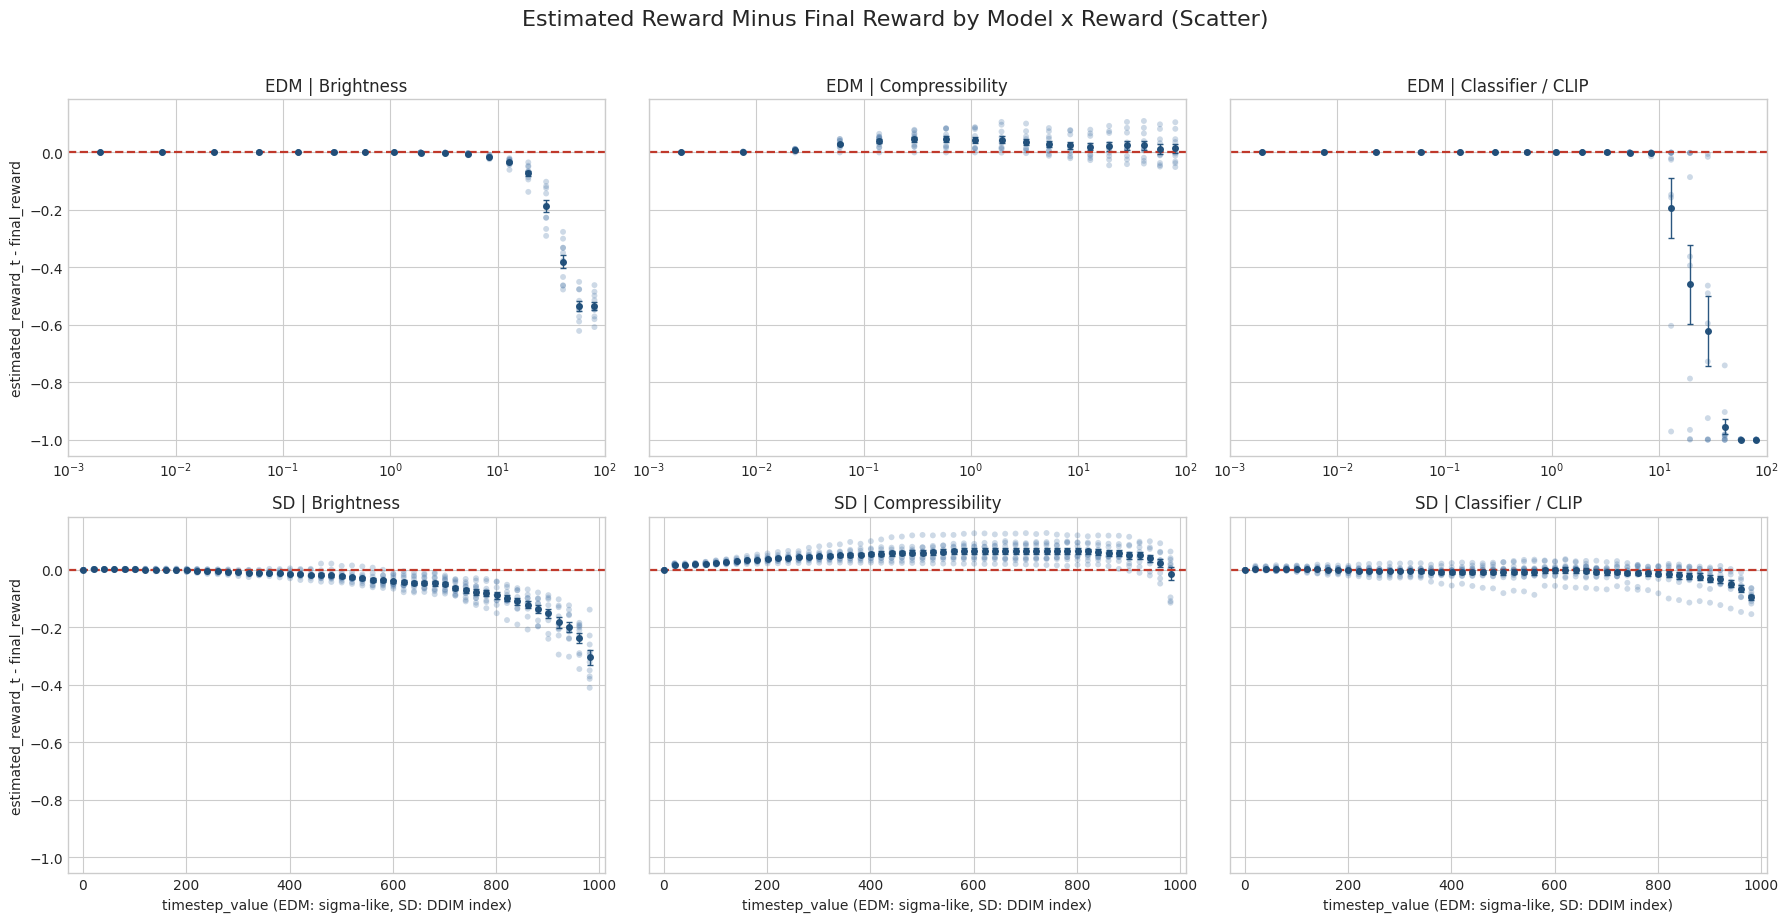

{'EDM': (0.001, 100.0), 'SD': (-28.4, 1010.4)}

In [27]:
def infer_model_xlim(model: str):
    manual = X_LIM_BY_MODEL.get(model)
    if manual is not None:
        return manual

    vals = []
    for col_key in COL_KEYS:
        curve = panel[(model, col_key)]['curve']
        if curve is None or curve.empty:
            continue
        vals.extend(curve['timestep_value'].dropna().tolist())

    if not vals:
        return None

    arr = np.asarray(vals, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return None

    scale = X_SCALE_BY_MODEL.get(model, 'log')
    if scale == 'log':
        arr = arr[arr > 0]
        if arr.size == 0:
            return None
        lo = 10 ** np.floor(np.log10(arr.min()))
        hi = 10 ** np.ceil(np.log10(arr.max()))
        if lo == hi:
            lo /= 10.0
            hi *= 10.0
        return (float(lo), float(hi))

    lo = float(arr.min())
    hi = float(arr.max())
    if lo == hi:
        lo -= 1.0
        hi += 1.0
    pad = 0.03 * (hi - lo)
    return (lo - pad, hi + pad)


xlim_by_model = {model: infer_model_xlim(model) for model in MODELS}

fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex='row', sharey=True)
for r, model in enumerate(MODELS):
    model_xlim = xlim_by_model.get(model)
    x_scale = X_SCALE_BY_MODEL.get(model, 'log')

    for c, col_key in enumerate(COL_KEYS):
        ax = axes[r, c]
        curve = panel[(model, col_key)]['curve']
        step_units = panel[(model, col_key)]['step_units']

        if curve is None or curve.empty or step_units is None or step_units.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} | {COL_LABELS[col_key]}')
            if x_scale == 'log':
                ax.set_xscale('log')
            if model_xlim is not None:
                ax.set_xlim(*model_xlim)
            continue

        # Raw per-unit scatter (one point per source/sample/timestep)
        x = step_units['timestep_value'].to_numpy(dtype=float)
        y = step_units['delta_est_minus_final'].to_numpy(dtype=float)
        mask = np.isfinite(x) & np.isfinite(y)
        if x_scale == 'log':
            mask = mask & (x > 0)

        ax.scatter(
            x[mask],
            y[mask],
            s=18,
            alpha=0.28,
            color='#4C78A8',
            edgecolors='none',
            label='Per-unit points',
        )

        # Overlay mean +/- SE at each timestep (no connecting line)
        cx = curve['timestep_value'].to_numpy(dtype=float)
        cy = curve['delta_mean'].to_numpy(dtype=float)
        ce = curve['delta_se'].to_numpy(dtype=float)
        cmask = np.isfinite(cx) & np.isfinite(cy) & np.isfinite(ce)
        if x_scale == 'log':
            cmask = cmask & (cx > 0)

        ax.errorbar(
            cx[cmask],
            cy[cmask],
            yerr=ce[cmask],
            fmt='o',
            ms=4,
            color='#1F4E79',
            ecolor='#1F4E79',
            elinewidth=1,
            capsize=2,
            alpha=0.95,
            label='Mean ± SE',
        )

        ax.axhline(0.0, color='#C0392B', linestyle='--', linewidth=1.6)
        ax.set_title(f'{model} | {COL_LABELS[col_key]}')

        if x_scale == 'log':
            ax.set_xscale('log')
            ax.xaxis.set_major_locator(LogLocator(base=10.0))
            ax.xaxis.set_major_formatter(LogFormatterMathtext(base=10.0))

        if model_xlim is not None:
            ax.set_xlim(*model_xlim)

for ax in axes[-1, :]:
    ax.set_xlabel('timestep_value (EDM: sigma-like, SD: DDIM index)')
for ax in axes[:, 0]:
    ax.set_ylabel('estimated_reward_t - final_reward')

fig.suptitle('Estimated Reward Minus Final Reward by Model x Reward (Scatter)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

xlim_by_model



In [28]:
summary_df


,model,column,reward_dir,log_dir,num_files,num_rows,num_units
0,EDM,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/EDM/BRIGHTNESS,1,14400,10
1,EDM,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/EDM/COMPRESS...,1,14400,10
2,EDM,classifier_or_clip,CLASSIFIER,../logs/search_stats/inefficiency/EDM/CLASSIFIER,1,14400,10
3,SD,brightness,BRIGHTNESS,../logs/search_stats/inefficiency/SD/BRIGHTNESS,10,40000,10
4,SD,compressibility,COMPRESSIBILITY,../logs/search_stats/inefficiency/SD/COMPRESSI...,10,40000,10
5,SD,classifier_or_clip,CLIP,../logs/search_stats/inefficiency/SD/CLIP,10,40000,10
